THE PROJECT REPOSITORY: https://github.com/zandmahsa/Modelling-of-synaptic-plasticity-project

Due to computational limitations of Google Colab, we were unable to run the STDP algorithm with a larger number of neurons or epochs. However, based on the current results and theoretical understanding, increasing these parameters would likely improve the accuracy of the network. With access to more computational resources, I would aim to run experiments with at least 500 neurons and more than 20 epochs, expecting the classification accuracy to improve significantly.


# Classification of Handwritten Digits Using Spiking Neural Networks on N-MNIST



## Project Overview

In this project, we aim to **classify handwritten digits from the N-MNIST dataset**, an event-based variant of the traditional MNIST dataset. The N-MNIST dataset contains asynchronous events captured by event-based vision sensors, which record changes in pixel intensity. We implement a Spiking Neural Network (**SNN**) using the **BindsNET** framework and employ two learning algorithms: spike-timing-dependent plasticity (**STDP**) and Reward-modulated STDP (**R-STDP**).

In this specific Colab implementation, we are focusing exclusively on **STDP** to train and evaluate the network. The comparison between STDP and R-STDP will be conducted using the same network architecture, and the results will be included in our final paper.

The models will be evaluated using key metrics such as **accuracy** and **F1-score**. This project aims to explore the potential of SNNs in real-time, event-driven tasks, particularly in the classification of handwritten digits.




# Step 1: Library Installation and Setup
In this section, we install the necessary libraries and set up the environment for the project:


*   **BindsNET:** We install BindsNET, a framework specifically designed for simulating Spiking Neural Networks (SNNs). We use it to implement the architecture of the network, the neurons, synapses, and the learning rule (STDP in this case).


*   **gdown:** This is used to download files from Google Drive. Here, we utilize it to download the N-MNIST dataset.


In [1]:
!pip install bindsnet # stable version
!pip install gdown
!pip install git+https://github.com/BindsNET/bindsnet.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for bindsnet: filename=bindsnet-0.2.7-py3-none-any.whl size=81400 sha256=d2edeafb32e0909bb82535ea2c9163818817f1697e8843e44b5c23686b23c6a8
  Stored in directory: /root/.cache/pip/wheels/94/06/3c/ce96902a847c6a788c61ba6a27ab52a3bdc9e2405f702bac30
Successfully built bindsnet
  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-n78pdi74
  Running command git clone --filter=blob:none --quiet https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-n78pdi74
  Resolved https://github.com/BindsNET/bindsnet.git to commit 091153c0b3ed9c718bffc35d4adc87c77ba5dd58
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.0 MB/



*   **numpy<2**: We ensure that we are using a compatible version of NumPy (below version 2), as BindsNET currently requires this version for compatibility reasons.







In [2]:
!pip install "numpy<2"

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bindsnet 0.3.2 requires numpy<3,>=2, but you have numpy 1.26.4 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.


In [3]:
# Add here necessary libraries
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gym
import gc
from gym import spaces
# Bindsnet needs to be installed
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre, MSTDP
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_weights, plot_voltages
from bindsnet.environment import Environment
from bindsnet.pipeline import EnvironmentPipeline
from bindsnet.environment import GymEnvironment



#  General Parameters for the Network

In this section, we define the general parameters for the network:


*   **n_neurons:** This defines the number of neurons in the output layer of the network. We have set it to 200 neurons.
*   **time:** Each sample is run for 300 timesteps to simulate the spiking activity in the network.
*   **n_train and n_test:** These specify the number of samples from the N-MNIST dataset used for training and testing, respectively.
*   **update_interval:** Determines how frequently (every 300 samples) the network updates during training.
*   **n_epochs:** The number of training iterations over the entire training dataset.



In [4]:
# Some general parameters (change as needed)
n_neurons = 200
time = 300  # Number of timesteps per sample
n_train = 1000  # Number of training samples
n_test = 200  # Number of test samples
update_interval = 300  # Update the network every 200 samples
n_epochs = 10

## Step 2: Downloading the N-MNIST Dataset

We begin by downloading and preparing the **N-MNIST dataset**. This dataset captures digit images using event-based vision sensors, producing asynchronous spike events for each sample. The data is divided into *excitatory (ON events)* and *inhibitory (OFF events)* spike events. Each spike represents changes in pixel intensity over time, making it a perfect fit for training spiking neural networks.

To handle the data efficiently, we implemented a custom NMNISTDataset class that loads the event data and converts it into spike tensors. These tensors are then fed into the network for training and evaluation.

### Key features of the dataset:

*   34x34 spatial resolution.
*   Temporal spike data for each digit.
*   Separate excitatory and inhibitory channels.
*   Training and testing sets.


In this section, we download the N-MNIST dataset from Google Drive using gdown and extract it into the nmnist directory. The dataset is split into training and test sets, containing spike-based event data for handwritten digits. This data is essential for the task of classifying digits using Spiking Neural Networks.

In [5]:
# Download N-MNIST dataset from Google Drive
!gdown '1f-GwPB4pv0vqd0BqVs4_NsVYB4UTjsc-' -O Train.zip
!gdown '1HAyMnpJdF_kxQEiO64D3P0ygImAfeg9f' -O Test.zip
!unzip -oq Train.zip -d nmnist
!unzip -oq Test.zip -d nmnist


Downloading...
From (original): https://drive.google.com/uc?id=1f-GwPB4pv0vqd0BqVs4_NsVYB4UTjsc-
From (redirected): https://drive.google.com/uc?id=1f-GwPB4pv0vqd0BqVs4_NsVYB4UTjsc-&confirm=t&uuid=873ed1e9-f55c-42a6-a630-3c3169206605
To: /content/Train.zip
100% 1.01G/1.01G [00:38<00:00, 26.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HAyMnpJdF_kxQEiO64D3P0ygImAfeg9f
From (redirected): https://drive.google.com/uc?id=1HAyMnpJdF_kxQEiO64D3P0ygImAfeg9f&confirm=t&uuid=c3419d0a-4e85-4869-96c0-273a8403ca93
To: /content/Test.zip
100% 170M/170M [00:01<00:00, 127MB/s] 


# Step 3: Custom Dataset Class: NMNISTDataset

Here, we define a custom dataset **class NMNISTDataset**, inheriting from torch.utils.data.Dataset. This class is responsible for loading, processing, and preparing the event-based data from the N-MNIST dataset.

## Key functionalities:

*   **Initialization**(__init__): The constructor takes several parameters like the root directory, training flag, transformation functions, and other parameters such as the time window and whether to separate excitatory and inhibitory spike events.
*  **Data Loading (load_data)**: This method loads the raw event data from the disk and processes it into spike events. It handles the loading for both training and test data and converts the data into spike tensors that are used as inputs to the SNN.


**Event Processing:**


*  **bytes_to_event**: This helper function converts a byte array into event data (x, y, polarity, time).
*   **events_to_spikes**: This function converts raw event data into spike tensors that can be fed into the neural network. It handles the temporal conversion of events and separates excitatory and inhibitory spikes.
*   **Shuffling and Get Item** (__getitem__): The dataset is shuffled, and each data sample is retrieved as spike tensors with the corresponding label.
define a custom class to load and use this data






In [6]:
class NMNISTDataset(Dataset):
    def __init__(self, root, train=True, transform=None, num_samples=None, time=None,
                 flatten=False, separate_exh_inh=False, cumulative=False, lazy=False, update_interval=update_interval):
        self.root = root
        self.train = train
        self.transform = transform
        self.flatten = flatten
        self.separate_exh_inh = separate_exh_inh
        self.cumulative = cumulative
        self.lazy = lazy
        self.time = time
        self.data, self.labels = self.load_data(num_samples=num_samples, update_interval=update_interval)
        self.idx_order = np.random.permutation(len(self.data))

    def shuffle(self):
        """Shuffle the order of samples."""
        self.idx_order = np.random.permutation(len(self.data))

    def load_data(self, num_samples=None, update_interval=300):
        """Load the dataset from the specified directory and convert it to spike events."""
        if self.train:
            data_path = os.path.join(self.root, 'Train')
        else:
            data_path = os.path.join(self.root, 'Test')

        data = []
        labels = []
        max_time = 320000  # Maximum time step for events

        for label in range(10):
            label_path = os.path.join(data_path, str(label))
            print(f"Loading {'training' if self.train else 'testing'} data for label {label} from {label_path}")

            if num_samples and (num_samples // 10 < len(os.listdir(label_path))):
                data_files = np.random.choice(os.listdir(label_path), num_samples // 10, replace=False)
            else:
                data_files = os.listdir(label_path)

            for i, file in enumerate(tqdm(data_files)):
                if (i + 1) % update_interval == 0:
                    print(f"Loaded {i + 1}/{len(data_files)} files for label {label}")
                labels.append(label)
                file_path = os.path.join(label_path, file)
                file_data = np.fromfile(file_path, dtype=np.uint8)

                if self.lazy:
                    data.append(file_data)
                else:
                    file_data = file_data.reshape(-1, 5)
                    event_data = np.apply_along_axis(self._bytes_to_event, 1, file_data)
                    spikes = self._events_to_spikes(event_data, max_time)
                    data.append(spikes)
                    del spikes
                    del event_data

                del file_data
                gc.collect()

        return data, labels

    def _events_to_spikes(self, events, max_time=320000):
        """Convert event data to spike tensors."""
        if self.time is not None:
            spikes = torch.zeros((self.time, 2 if self.separate_exh_inh else 1, 34, 34))
            time_step = np.ceil(max_time / self.time)
        else:
            spikes = torch.zeros((max_time, 2 if self.separate_exh_inh else 1, 34, 34))

        for event in events:
            x = event[0]
            y = event[1]
            p = event[2]
            t = event[3]
            if self.time is not None:
                t = int(t / time_step)
            if self.separate_exh_inh:
                if self.cumulative:
                    spikes[t:, 1 if p else 0, y, x] = 1
                else:
                    spikes[t, 1 if p else 0, y, x] = 1
            else:
                if self.cumulative:
                    spikes[t:, 0, y, x] = p
                else:
                    spikes[t, 0, y, x] = p

        if self.flatten:
            spikes = spikes.view(self.time, *([2, -1] if self.separate_exh_inh else [-1]))

        return spikes

    def _bytes_to_event(self, bytes_data):
        """Convert a byte array to event data (x, y, polarity, time)."""
        bits = bin(int.from_bytes(bytes_data, byteorder='big'))[2:]
        bits = '0' * (40 - len(bits)) + bits
        x = int(bits[:8], 2)
        y = int(bits[8:16], 2)
        p = int(bits[16:17], 2)
        t = int(bits[17:], 2)
        event = np.array((np.uint8(x), np.uint8(y), np.bool_(p), np.uint32(t)))
        return event

    def __len__(self):
        """Return the number of samples."""
        return len(self.data)

    def __getitem__(self, idx):
        """Return the sample and label at the given index."""
        if self.lazy:
            file_data = self.data[self.idx_order[idx]].reshape(-1, 5)
            event_data = np.apply_along_axis(self._bytes_to_event, 1, file_data)
            sample = self._events_to_spikes(event_data)
        else:
            sample = self.data[self.idx_order[idx]]
        label = self.labels[self.idx_order[idx]]

        if self.transform:
            sample = self.transform(sample)

        return {'spikes': sample, 'label': label}


## Loading the Dataset
We create two instances of the NMNISTDataset class to load the training and testing datasets. The dataset is structured to contain separate channels for excitatory and inhibitory spike events (using separate_exh_inh=True), ensuring that the spiking input is biologically plausible. Each sample is processed for the defined time window (time=300 timesteps) and contains spiking data for each pixel location over time.

In [7]:
# Load training and test dataset with two channels (excitatory and inhibitory)
train_dataset = NMNISTDataset(root='nmnist', train=True, num_samples=n_train, time=time, separate_exh_inh=True)
test_dataset = NMNISTDataset(root='nmnist', train=False, num_samples=n_test, time=time, separate_exh_inh=True)

Loading training data for label 0 from nmnist/Train/0


100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


Loading training data for label 1 from nmnist/Train/1


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


Loading training data for label 2 from nmnist/Train/2


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Loading training data for label 3 from nmnist/Train/3


100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


Loading training data for label 4 from nmnist/Train/4


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


Loading training data for label 5 from nmnist/Train/5


100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


Loading training data for label 6 from nmnist/Train/6


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Loading training data for label 7 from nmnist/Train/7


100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Loading training data for label 8 from nmnist/Train/8


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


Loading training data for label 9 from nmnist/Train/9


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Loading testing data for label 0 from nmnist/Test/0


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loading testing data for label 1 from nmnist/Test/1


100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


Loading testing data for label 2 from nmnist/Test/2


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loading testing data for label 3 from nmnist/Test/3


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


Loading testing data for label 4 from nmnist/Test/4


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loading testing data for label 5 from nmnist/Test/5


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loading testing data for label 6 from nmnist/Test/6


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Loading testing data for label 7 from nmnist/Test/7


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loading testing data for label 8 from nmnist/Test/8


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Loading testing data for label 9 from nmnist/Test/9


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


# Step 4: Review the data
To ensure that the data is loaded correctly and ready to be used in the model, we load the training and testing datasets and then check the distribution of labels across both sets. This step helps verify that the data is balanced and correctly structured for training the model.

Loading the Dataset: Both the training and test datasets are loaded with two channels (excitatory and inhibitory spike events) using the NMNISTDataset class.
Data Verification: The check_data function iterates over the dataset and counts the occurrences of each label (0-9) to ensure that the data distribution is correct.
By examining the label distribution in both the training and test datasets, we can confirm that the data is structured as expected.

In [8]:
# Check the distribution of the loaded data
def check_data(dataset):
    label_counts = {i: 0 for i in range(10)}  # Create a dictionary to count tags
    for i in range(len(dataset)):  # Scroll through the samples in the dataset
        sample = dataset[i]
        label = sample['label']
        label_counts[label] += 1
    print("Label distribution:", label_counts)

# Examining educational data
print("Checking training dataset:")
check_data(train_dataset)

# Examining test data
print("Checking testing dataset:")
check_data(test_dataset)

Checking training dataset:
Label distribution: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}
Checking testing dataset:
Label distribution: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20}


# Step 5: Implement sample selection and display for STDP

This section focuses on selecting a few representative samples from the dataset for each label (digit) and then visualizing the spiking activity of these samples. The goal is to better understand the spike patterns that are used as inputs to the Spiking Neural Network (SNN), especially when using the STDP learning rule.

**Sample Selection by Label:**

The function select_samples_by_label is responsible for selecting a specified number of samples (num_samples_per_label) for each digit (0-9) from the dataset. This function ensures that at least one sample from each label is included for visualization purposes.

In [9]:
# Function to select a number of examples of each label in the dataset
def select_samples_by_label(dataset, num_samples_per_label=1):
    label_samples = {i: [] for i in range(10)}
    for i in range(len(dataset)):
        sample = dataset[i]
        label = sample['label']
        if len(label_samples[label]) < num_samples_per_label:
            label_samples[label].append(sample)
        if all(len(label_samples[l]) >= num_samples_per_label for l in range(10)):
            break
    return label_samples


# Step 6: Display the selected samples

**Displaying Selected Samples:**

The function plot_samples visualizes the selected samples for each label by plotting the accumulated spike patterns. These spike patterns are displayed for both excitatory and inhibitory channels, and the difference between them is also shown.

In [10]:
# Function to display selected samples from each label
def plot_samples(label_samples, time_window=300, flatten=False, separate_exh_inh=False):
    if separate_exh_inh:
        fig, axes = plt.subplots(3, len(label_samples.items()), figsize=(20, 6))
    else:
        fig, axes = plt.subplots(1, len(label_samples.items()), figsize=(20, 6))

    for label, samples in label_samples.items():
        for i, sample in enumerate(samples):
            spikes = sample['spikes']

            # Display spikes individually
            if separate_exh_inh:
                img_exh = np.zeros_like(spikes[0, 1].numpy())
                img_inh = np.zeros_like(spikes[0, 0].numpy())
                for t in range(spikes.shape[0]):
                    img_exh += spikes[t, 1].numpy() if spikes.size(1) > 1 else spikes[t, 0].numpy()
                    img_inh += spikes[t, 0].numpy()
            else:
                img = np.zeros_like(spikes[0, 0].numpy())
                for t in range(spikes.shape[0]):
                    img += spikes[t, 0].numpy()

            if flatten:
                if separate_exh_inh:
                    img_exh = img_exh.reshape(34, 34)
                    img_inh = img_inh.reshape(34, 34)
                else:
                    img = img.reshape(34, 34)

            if separate_exh_inh:
                axes[0, label].imshow(img_inh, cmap='viridis', interpolation='nearest')
                axes[0, label].set_title(f'Label: {label} (Inh)')
                axes[0, label].axis('off')
                axes[1, label].imshow(img_exh, cmap='viridis', interpolation='nearest')
                axes[1, label].set_title(f'Label: {label} (Exh)')
                axes[1, label].axis('off')
                axes[2, label].imshow(img_exh - img_inh, cmap='viridis', interpolation='nearest')
                axes[2, label].set_title(f'Label: {label} (Exh - Inh)')
                axes[2, label].axis('off')
            else:
                axes[label].imshow(img, cmap='viridis', interpolation='nearest')
                axes[label].set_title(f'Label: {label}')
                axes[label].axis('off')

    plt.show()


**Sample Selection and Visualization:**

After defining the functions, we use them to:




*   Select samples: From the training dataset using select_samples_by_label.
*   Plot the selected samples: Displaying the spike patterns for each digit



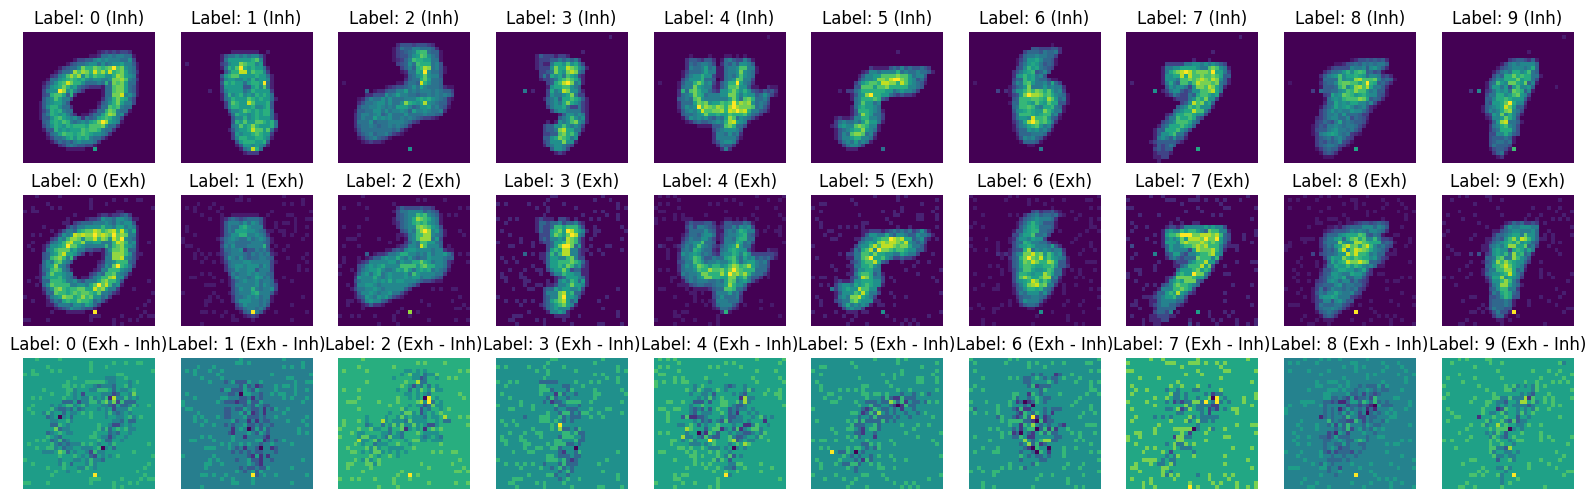

In [11]:
# Selecting samples from the training dataset
train_label_samples = select_samples_by_label(train_dataset)

# Show spikes and samples with two channels
plot_samples(train_label_samples, flatten=True, separate_exh_inh=True)


# Step 7: Define the spiking neural network

In this step, we implement a biologically-inspired Spiking Neural Network (SNN), which is a powerful computational model for processing temporal data such as event-based vision inputs. The SNN leverages the natural dynamics of spikes, or action potentials, to process information in a way that mimics the behavior of biological neurons. Unlike traditional neural networks, which use continuous activations, spiking neurons fire discrete spikes when their membrane potentials cross a certain threshold.

**Network Architecture**
Our SNN consists of the following components:

***Input Layers:***
Two separate input layers are designed to handle excitatory and inhibitory spike events. These layers process input data from the N-MNIST dataset, which consists of 34x34 pixel event data over a given time window. By separating excitatory and inhibitory inputs, the network can model more complex patterns of neural interactions, similar to biological systems.

***Output Layer:***
The output layer consists of Leaky Integrate-and-Fire (LIF) neurons. The LIF neuron model is a commonly used spiking neuron model that integrates incoming spikes over time. The neuron's membrane potential decays with time, and when the potential exceeds a threshold, the neuron fires a spike. This dynamic is particularly well-suited for temporal data processing, as it allows neurons to accumulate input signals over time, much like real neurons in the brain.

***Synaptic Connections:***
We establish connections between the input and output layers, where the weight of each synapse determines how much influence an incoming spike from the input layer has on the membrane potential of the neurons in the output layer. These synaptic weights are initialized randomly to ensure diversity in learning. Importantly, the weights are modifiable during training through the Spike-Timing-Dependent Plasticity (STDP) learning rule.

***Spike-Timing-Dependent Plasticity (STDP):***
The STDP learning rule is a form of unsupervised learning that modifies synaptic weights based on the relative timing of pre- and post-synaptic spikes. If a pre-synaptic spike precedes a post-synaptic spike within a certain window, the synaptic strength is increased (potentiation). Conversely, if the pre-synaptic spike follows the post-synaptic spike, the synaptic strength is decreased (depression). This rule allows the network to naturally learn temporal correlations in the input data without the need for explicit labels.

***For our network:***
Excitatory connections receive weight updates that strengthen when pre-synaptic spikes occur just before post-synaptic spikes.
Inhibitory connections act to suppress spikes when the timing suggests that the input is not informative for the current task.
This biologically plausible mechanism enables the network to refine its synaptic strengths dynamically during training, leading to better recognition of temporal patterns in the input data.

***Monitoring and Analysis***
We use monitors to track the dynamics of the network during training. The spike activity (s) and membrane potentials (v) of the neurons in the output layer are recorded at every time step. These monitors provide valuable insights into how the network learns over time, allowing us to analyze the spiking behavior and membrane potential fluctuations during both training and testing.

***Spike monitor:*** Tracks the spikes generated by neurons in the output layer, which is essential for understanding how the network's output evolves during the simulation.

***Voltage monitor: ***Captures the internal membrane potential dynamics of the neurons, providing insights into how close a neuron is to firing a spike.

In [12]:
# Define the network
network = Network()

# Excitatory input layer
input_layer_exh = Input(n=34*34, traces=True)  # 34x34 neurons
# Inhibitory input layer
input_layer_inh = Input(n=34*34, traces=True)  # 34x34 neurons
# Output layer (number of neurons adjustable)
output_layer = LIFNodes(n=n_neurons, traces=True, thresh=-50.0)  # n_neurons in the output layer

# Add layers to the network
network.add_layer(input_layer_exh, name='exh')
network.add_layer(input_layer_inh, name='inh')
network.add_layer(output_layer, name='output')

# Connections between input and output layers
connection_exh = Connection(source=input_layer_exh, target=output_layer, w=0.05 + 0.1*torch.randn(input_layer_exh.n, output_layer.n))
connection_inh = Connection(source=input_layer_inh, target=output_layer, w=0.05 + 0.1*torch.randn(input_layer_inh.n, output_layer.n))

# Add connections to the network (without the learning rule)
network.add_connection(connection_exh, source='exh', target='output')
network.add_connection(connection_inh, source='inh', target='output')

# Define learning rules for excitatory and inhibitory connections
update_rule_exh = PostPre(connection_exh, nu=(5e-4, 5e-3))  # Learning rate for excitatory connection
update_rule_inh = PostPre(connection_inh, nu=(5e-4, 5e-3))  # Learning rate for inhibitory connection

# Apply the learning rules separately (not in add_connection)
connection_exh.update_rule = update_rule_exh
connection_inh.update_rule = update_rule_inh

# Monitor spikes and voltages
output_monitor = Monitor(obj=output_layer, state_vars=('s', 'v'), time=time)
network.add_monitor(output_monitor, name='output_spikes')

voltage_monitor = Monitor(obj=output_layer, state_vars=('v',), time=time)
network.add_monitor(voltage_monitor, name='voltages')

# Step 8: Network training with STDP
In this step, we train the Spiking Neural Network (SNN) using the Spike-Timing-Dependent Plasticity (STDP) algorithm. The STDP rule we are implementing is the PostPre learning rule, which adjusts the synaptic weights based on the timing of spikes between the pre- and post-synaptic neurons. As the network processes each sample from the training dataset, it updates the weights dynamically based on this learning rule. After each iteration, the network states (spikes and membrane potentials) are saved for analysis.


***Data Preparation:*** The input data, consisting of excitatory and inhibitory spike events, is reshaped and fed into the network.

***Training Process:*** The network processes each input sample over a defined time window, updating its internal states (spikes and membrane potentials) and adjusting synaptic weights according to the STDP rule.

***State Monitoring:*** Spikes and voltages from the output neurons are recorded after each training step, allowing for analysis of the network's learning dynamics.

***Reset:*** After each sample, the network’s state variables are reset to ensure independent learning for each input.


In [13]:
# Create array to store spikes and voltages during training
'''
We create two tensors to store the spikes and voltages of the neurons in the output layer during training.
These records will be helpful for later analysis of the network's behavior over time
'''

spikes_record_output = torch.zeros(n_train, time, n_neurons)
voltages_record_output = torch.zeros(n_train, time, n_neurons)


# Start network training
for epoch in range(n_epochs):
    for i in tqdm(range(n_train)):
        inputs = {
          'exh': train_dataset[i]['spikes'][:, 1, :].view(time, -1),  # Excitatory channel (reshape)
          'inh': train_dataset[i]['spikes'][:, 0, :].view(time, -1),  # Inhibitory channel (reshape)
        }

        network.run(inputs=inputs, time=time)

        # Save spikes and voltages
        spikes_record_output[i] = output_monitor.get('s').view(time, -1)
        voltages_record_output[i] = output_monitor.get('v').view(time, -1)


        network.reset_state_variables()


100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s]


# Step 9: Network Assessment
After training, the network's performance is assessed using two common metrics: Accuracy and F1-score. These metrics help evaluate the model’s ability to classify the handwritten digits from the N-MNIST dataset.



# Evaluate with F1 and Accuracy criteria

The accuracy is calculated as the percentage of correctly classified samples.
The F1-score (macro average) provides a balanced evaluation of the model across all digit classes, considering both precision and recall.

In [14]:
!pip install scikit-learn

In [15]:
from sklearn.metrics import f1_score, accuracy_score

In [16]:
network.train(False)

true_labels = []
predicted_labels = []

for i in range(n_test):
    inputs = {
        'exh': test_dataset[i]['spikes'][:, 1, :].view(time, -1),  # excitatory
        'inh': test_dataset[i]['spikes'][:, 0, :].view(time, -1),  # inhibitory
    }

    network.run(inputs=inputs, time=time)

    output_spikes = output_monitor.get('s').view(time, -1)

    spike_counts = torch.sum(output_spikes, dim=0)

    predicted_label = torch.argmax(spike_counts).item()

    true_labels.append(test_dataset[i]['label'])
    predicted_labels.append(predicted_label)

    network.reset_state_variables()

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-score (macro average): {f1:.2f}")
print(output_spikes)
print(spike_counts)


Accuracy: 10.00%
F1-score (macro average): 0.02
tensor([[False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor([47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47

# Step 10: Display the final weights after training
After completing the training and evaluation, the final learned weights of the network are visualized to understand how the network has adapted to the input data over time.

Final Weights: Excitatory to Output Layer


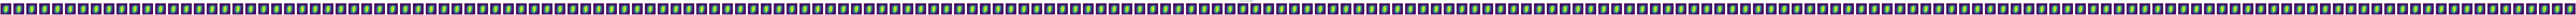

Parameter containing:
tensor([[12.8985, 13.0761, 13.0012,  ..., 13.0808, 12.9387, 13.2070],
        [ 7.7708,  7.7340,  7.8105,  ...,  7.7287,  7.7040,  7.6900],
        [ 2.9873,  3.1729,  2.9416,  ...,  3.0999,  2.9788,  3.0644],
        ...,
        [22.4383, 22.3628, 22.5156,  ..., 22.4452, 22.4113, 22.4853],
        [11.4150, 11.5420, 11.4056,  ..., 11.2865, 11.3739, 11.3737],
        [18.0774, 17.8320, 17.9857,  ..., 17.8762, 17.9876, 18.0059]])
Final Weights: Inhibitory to Output Layer


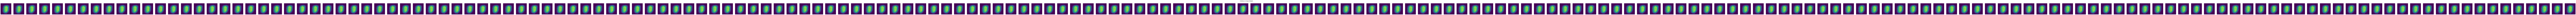

Parameter containing:
tensor([[12.8985, 13.0761, 13.0012,  ..., 13.0808, 12.9387, 13.2070],
        [ 7.7708,  7.7340,  7.8105,  ...,  7.7287,  7.7040,  7.6900],
        [ 2.9873,  3.1729,  2.9416,  ...,  3.0999,  2.9788,  3.0644],
        ...,
        [22.4383, 22.3628, 22.5156,  ..., 22.4452, 22.4113, 22.4853],
        [11.4150, 11.5420, 11.4056,  ..., 11.2865, 11.3739, 11.3737],
        [18.0774, 17.8320, 17.9857,  ..., 17.8762, 17.9876, 18.0059]])


In [18]:

#Display the final weights from the input layer to the output layer.

def plot_weights(weights, n_neurons, input_shape=(34, 34), title="Weights"):

    fig, axes = plt.subplots(1, n_neurons, figsize=(n_neurons * 3, 3))  # Increased the figsize for larger images

    for i in range(n_neurons):
        weight_matrix = weights[:, i].view(*input_shape).detach().cpu().numpy()
        axes[i].imshow(weight_matrix, cmap="viridis", interpolation="nearest")
        axes[i].axis('off')

    plt.suptitle(title)
    plt.show()


print("Final Weights: Excitatory to Output Layer")
plot_weights(connection_exh.w, n_neurons=n_neurons, title="Excitatory to Output Weights")
print(connection_exh.w)

print("Final Weights: Inhibitory to Output Layer")
plot_weights(connection_inh.w, n_neurons=n_neurons, title="Inhibitory to Output Weights")
print(connection_exh.w)

Final Weights: Excitatory to Output Layer


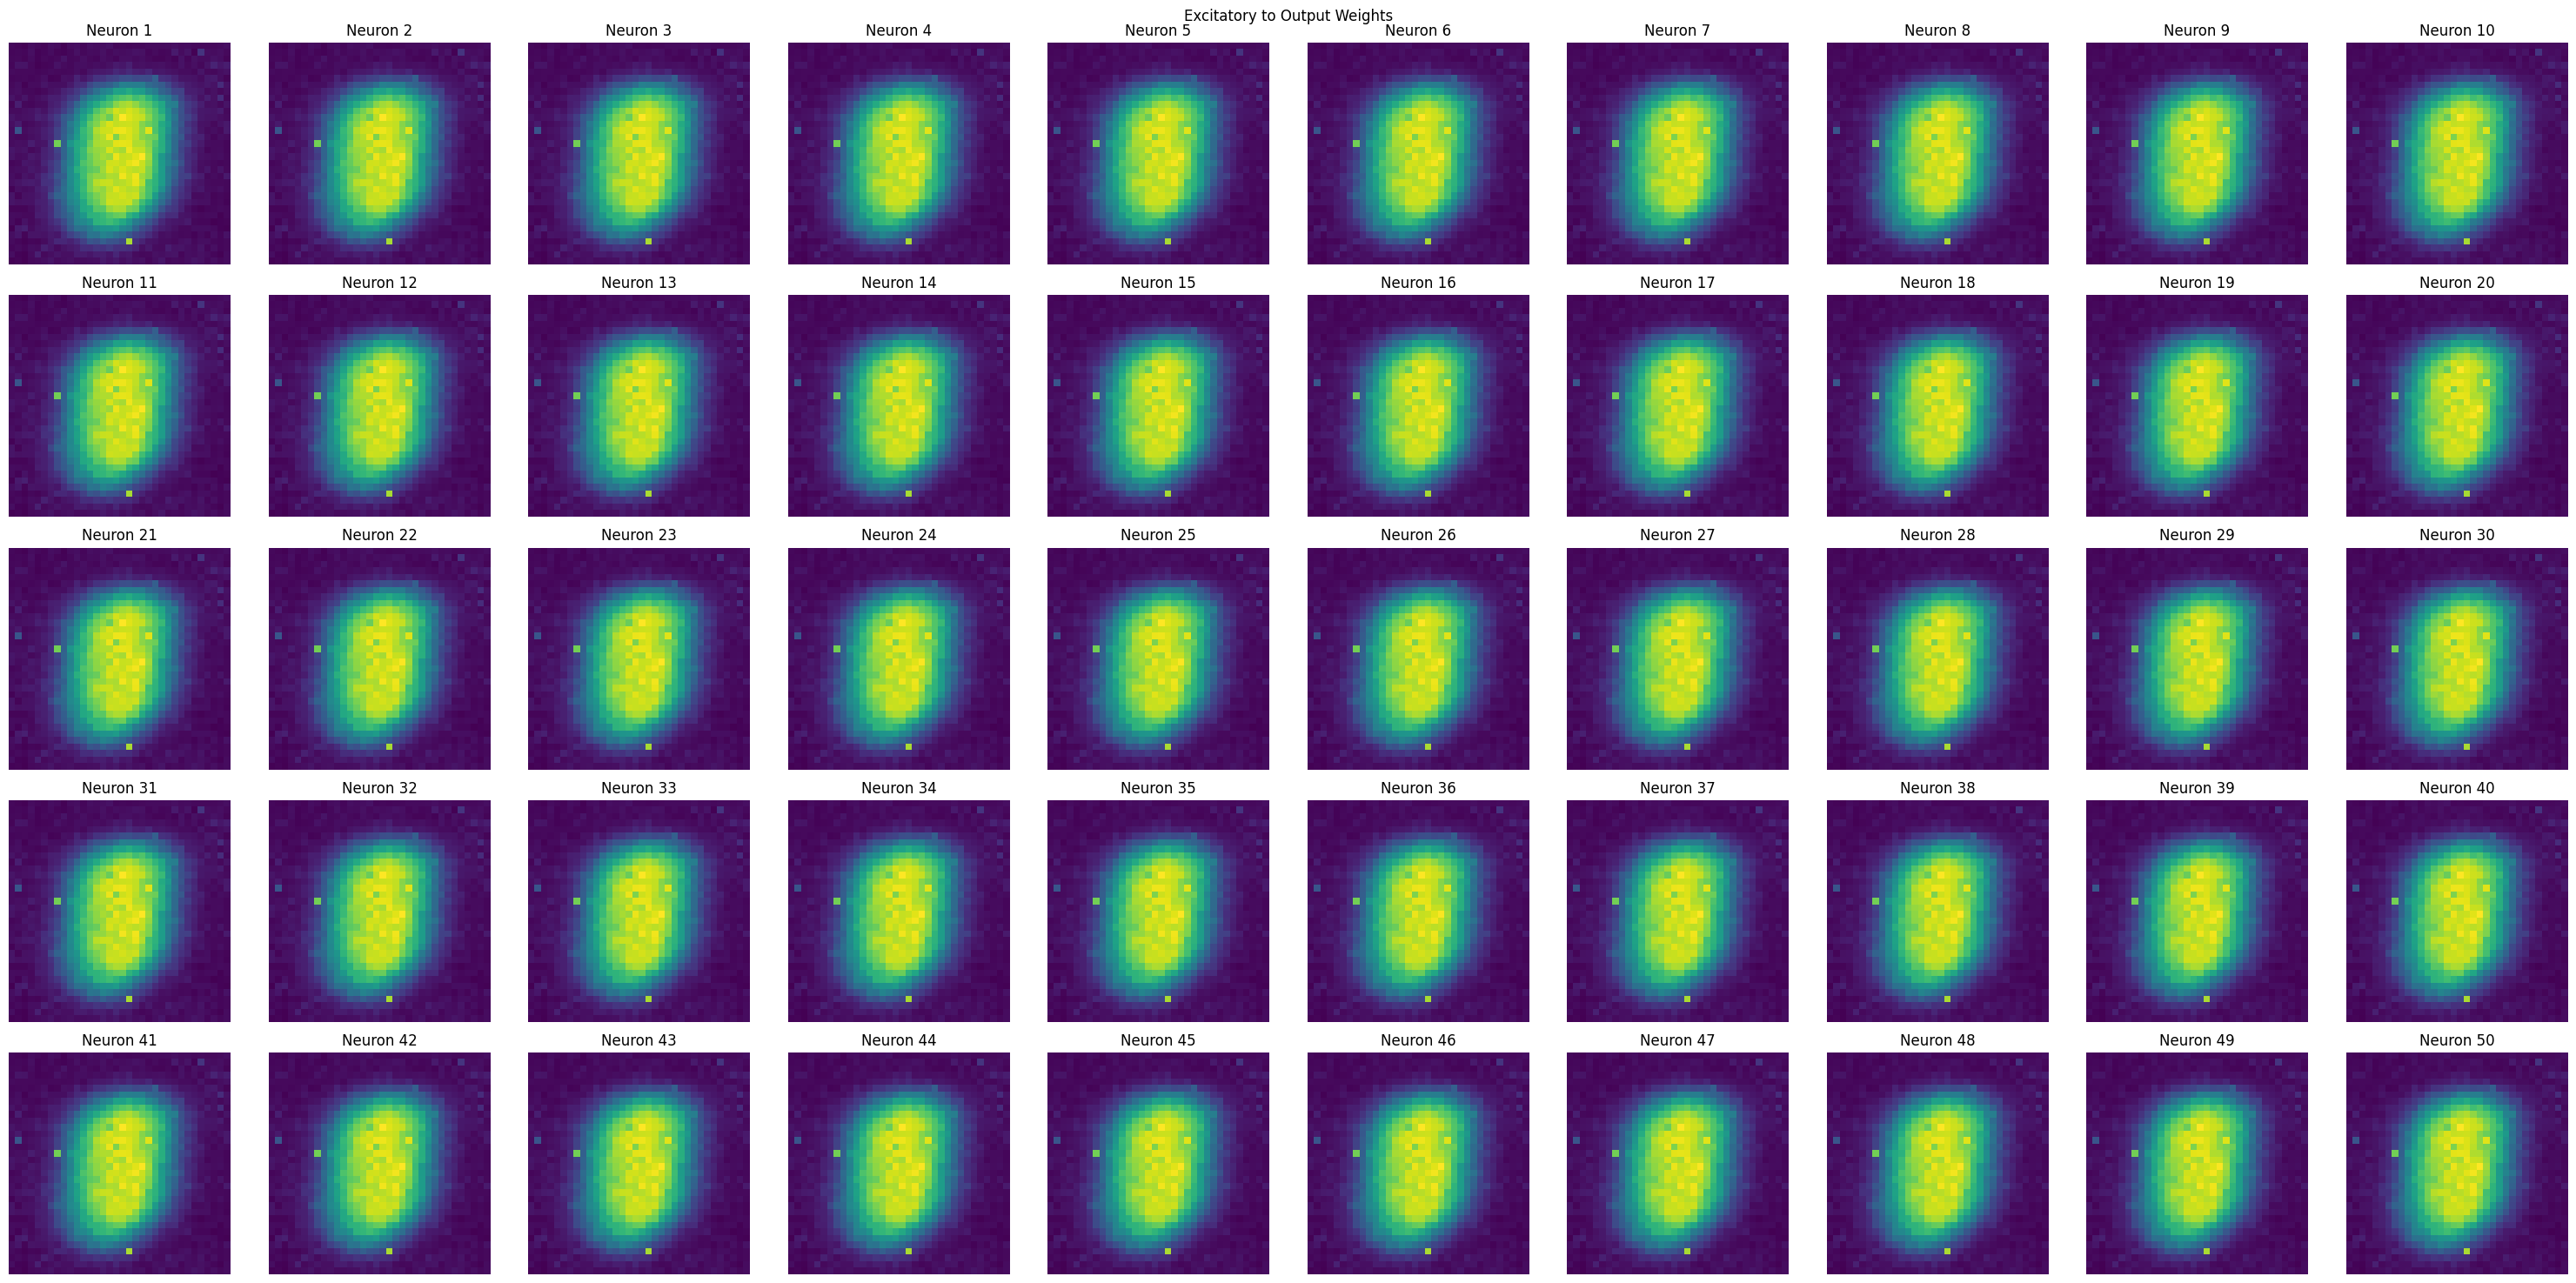

Final Weights: Inhibitory to Output Layer


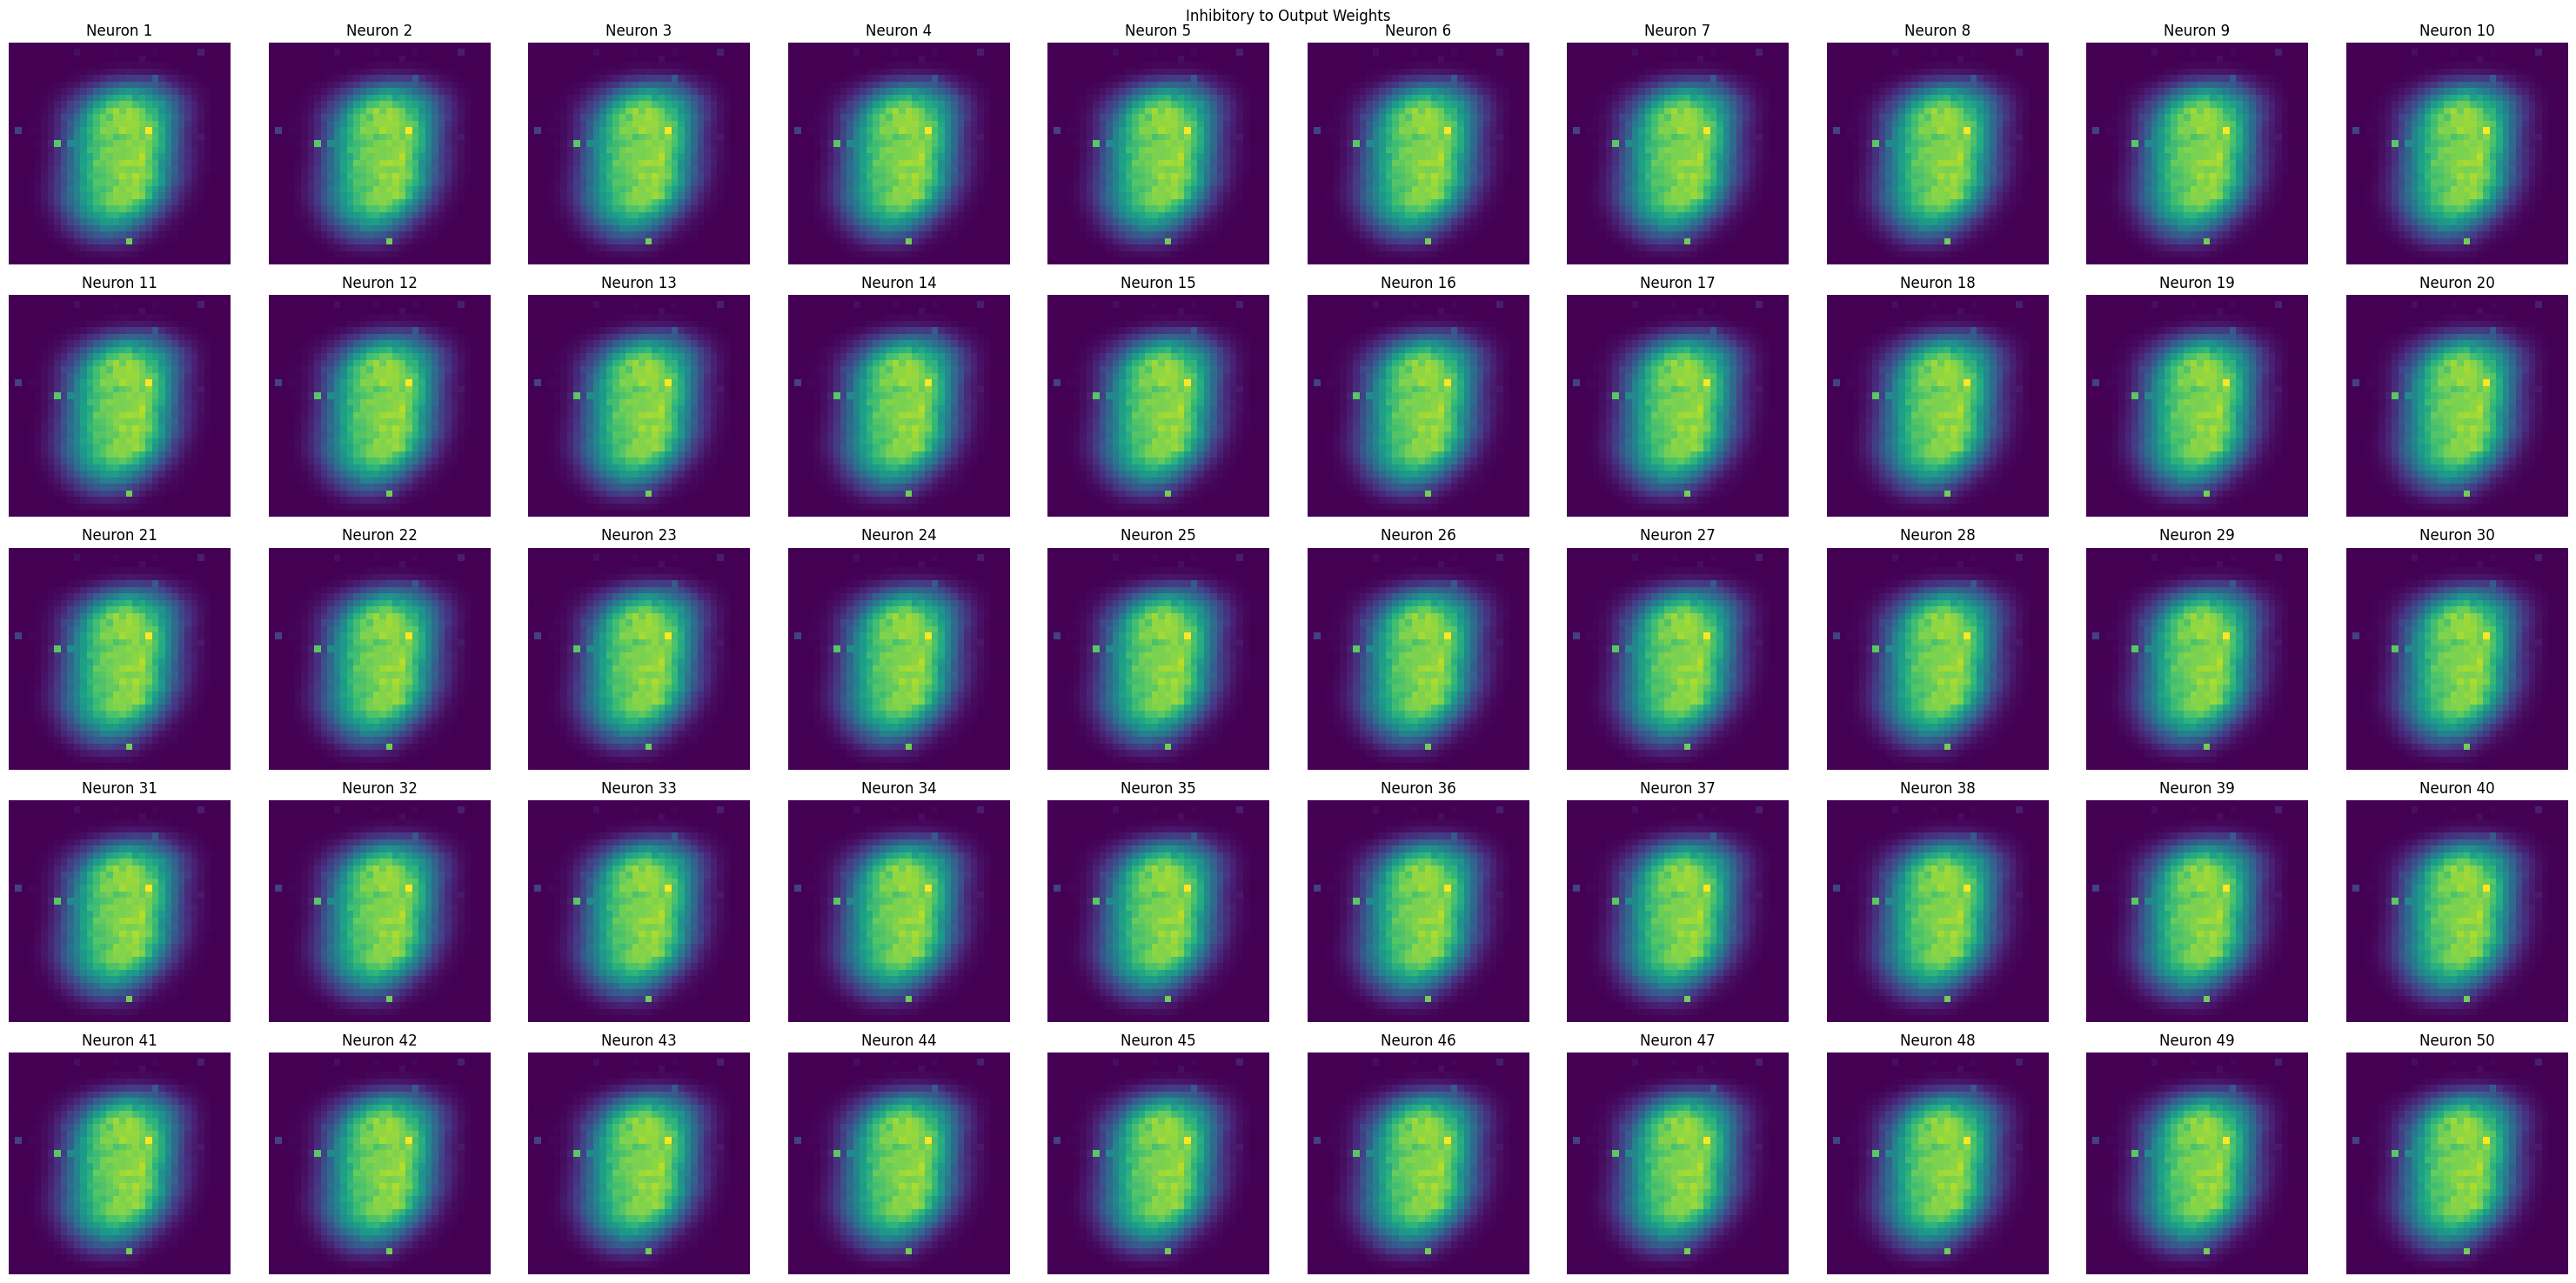

In [19]:
def plot_weights(weights, n_neurons, input_shape=(34, 34), title="Weights", max_neurons_display=50):

    if n_neurons > max_neurons_display:
        n_neurons = max_neurons_display

    n_cols = 10
    n_rows = (n_neurons + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axes = axes.flatten()
    for i in range(n_neurons):
        weight_matrix = weights[:, i].view(*input_shape).detach().cpu().numpy()
        ax = axes[i]
        im = ax.imshow(weight_matrix, cmap="viridis", interpolation="nearest")
        ax.axis('off')
        ax.set_title(f'Neuron {i + 1}')

    for ax in axes[n_neurons:]:
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


print("Final Weights: Excitatory to Output Layer")
plot_weights(connection_exh.w, n_neurons=n_neurons, title="Excitatory to Output Weights")

print("Final Weights: Inhibitory to Output Layer")
plot_weights(connection_inh.w, n_neurons=n_neurons, title="Inhibitory to Output Weights")


# NOTE

# Limitations and Future Improvements
During the development of this project, we faced certain limitations that affected the scale and depth of experimentation. The primary issue was related to the computational limitations of Google Colab, which restricted the ability to run larger-scale experiments with more neurons, longer training times (epochs), and more complex configurations. Despite these constraints, the results provide valuable insights into the performance of STDP for classifying handwritten digits in the N-MNIST dataset.


# Key Limitations:

***Limited Number of Neurons and Epochs:*** Due to memory and processing power limitations in Colab, I could only use 200 neurons and train the model for 10 epochs. Ideally, the number of neurons could be increased to 500 or more, and more epochs (e.g., 50+) could help the network converge better and yield higher accuracy.

***Hyperparameter Tuning:*** Although I tuned basic parameters like learning rate and number of neurons, I was unable to run an extensive hyperparameter search due to time and resource constraints. With more resources, I would explore a wider range of hyperparameters to find the optimal configuration.

***Limited Scope for Comparison:*** This colab file only implements STDP, and due to the scope of the project and time constraints, a direct comparison with other learning algorithms (R-STDP) was not possible. In future work, comparing STDP with other plasticity rules would provide a more comprehensive understanding of the benefits and trade-offs between different algorithms.
